# Earth Model

v4 - for Ozone and Sea Ice visualisations

This uses more managable topography/bathymetry data from PNG files, can be adapted to use NetCDF version if more detail is required in the topography but rendering framerates will be reduced and download time is longer

### Data sources:

#### Colour texture
- Blue marble: https://www.h-schmidt.net/map/download/world_shaded_43k.jpg
- Shaded relief (public domain) https://www.shadedrelief.com/natural3/pages/textures.html
- http://shadedrelief.com/natural3/ne3_data/16200/textures/4_no_ice_clouds_mts_16k.jpg

#### Ocean / water mask:
- https://www.shadedrelief.com/natural3/pages/extra.html
- http://shadedrelief.com/natural3/ne3_data/8192/masks/water_8k.png

#### DEM topography (21600x10800)
- https://visibleearth.nasa.gov/images/73934/topography
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png

#### DEM bathymetry (21600x10800)
- https://visibleearth.nasa.gov/images/73963/bathymetry
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73963/gebco_08_rev_bath_21600x10800.png

Combined topo / bath full dataset (86400 x 43200) not used, but here for reference:
- NC version: https://www.bodc.ac.uk/data/open_download/gebco/gebco_2020/zip/

In [1]:
#SETTINGS 
background = 'black' # 'darkgrey'
#Enable topography?
use_topo = True #False

#Enable bathymetry?
use_bath = True
combine_bath = False #Combine with the topo data for single dataset

topo_tex = 'gebco_08_rev_elev_21600x10800.png'
bath_tex = 'gebco_08_rev_bath_21600x10800.png'

#Mono land/water mask
#colour_tex = '../water_8k.png'
#Mono land/water mask with grid
#colour_tex = 'gridmap.png'
#Blue marble
#colour_tex = 'world_shaded_43k.jpg'
#Shaded relief
colour_tex = '3_no_ice_clouds_16k.jpg'
tag = '_relief'
#Colour only, no relief
colour_tex = '4_no_ice_clouds_mts_16k.jpg'
tag = '_flat'

if combine_bath:
    tag += '_bath'

#res = 1
res = 2
if res == 0:
    GRIDRES = 512 #For testing or older GPU / less gpu ram
    TEXRES = 1024  #Resolution of the colour texture - defines the colour detail
    res_tag = '_low'
elif res == 1:
    GRIDRES = 2048 #Mid-range
    TEXRES = 4096  #Resolution of the colour texture - defines the colour detail
    res_tag = ''
elif res == 2:
    #Too high res for machine without high memory
    GRIDRES = 4096
    TEXRES = 8192  #Resolution of the colour texture - defines the colour detail
    res_tag = '_high'   #Avoid overwriting files by adding tag per setting change
tag += res_tag
#tag = '_grid_grey' #Avoid overwriting files by adding tag per setting change

desaturate = False #for colour surface texture

#Earth's radius ~6371km - we'll use 1000's of km units (Mm)
radius = 6371 * 1e-3 #Radius in Mm

In [2]:
try:
    import sys
    sys.path.insert(0, '../..') #for accessvis module
    import accessvis
    import lavavu
    import numpy as np
    import math
    import os
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from PIL import Image
    Image.MAX_IMAGE_PIXELS = 1061683200
    
except (ImportError) as e:
    print('ImportError: Installing dependencies, please run this cell again...')
    !pip install pillow lavavu
    raise('Installed dependencies, please run this cell again')

In [3]:
if not os.path.exists(colour_tex):
    url = f'http://shadedrelief.com/natural3/ne3_data/16200/textures/{colour_tex}'
    lavavu.download(url, colour_tex)
if not os.path.exists(topo_tex):
    url = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png'
    lavavu.download(url, topo_tex)
if not os.path.exists(bath_tex):
    url = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73963/gebco_08_rev_bath_21600x10800.png'
    lavavu.download(url, bath_tex)


In [4]:
if colour_tex == 'gridmap.png': # and not os.path.exists(colour_tex):
    water_mask = 'water_8k.png'
    if not os.path.exists(water_mask):
        url = 'http://shadedrelief.com/natural3/ne3_data/8192/masks/water_8k.png'
        lavavu.download(url)
    #Open land/water mask as base image
    accessvis.draw_latlon_grid(water_mask, 'gridmap.png', lat=30, lon=30)    


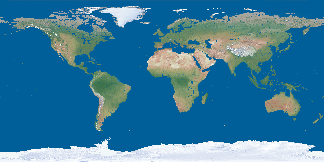

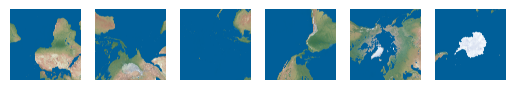

In [5]:
#Split the colour texture image into cube map tiles
fn = colour_tex
orig = Image.open(fn)
greyscale = orig.convert('L')
if desaturate:
    col = np.array(greyscale)
else:
    col = np.array(orig)

#Renders a downsampled view
image = lavavu.Image(data=np.array(orig)[::50, ::50])
image.display()

#Export individial textures
force = False #True
if force or not os.path.exists('F' + tag + '.png'):
    textures = accessvis.split_tex(col, TEXRES) 
    #Write colour texture tiles
    for f in ['F', 'R', 'B', 'L', 'U', 'D']:
        tfn = f + tag + '.png'
        if force or not os.path.exists(tfn):
            tex = lavavu.Image(data=textures[f])
            tex.save(tfn)

# display images
%matplotlib inline
fig, ax = plt.subplots(1,6) #, figsize=(12, 2))
for i,f in enumerate(['F', 'R', 'B', 'L', 'U', 'D']):
    ax[i].imshow(mpimg.imread(f + tag + '.png'))
    ax[i].axis('off')

# DEM

In [6]:
height = data = np.array(Image.open(topo_tex))
print(height.shape, height.min(), height.max(), height.dtype)

(10800, 21600) 0 255 uint8



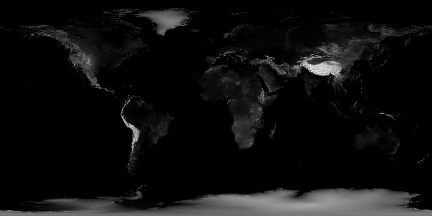

In [7]:
#Renders a jpeg downsampled view
height = height.reshape(height.shape[0],height.shape[1],1)
image = lavavu.Image(data=height[::50, ::50])
image.display()

(10800, 21600) 0 255 uint8



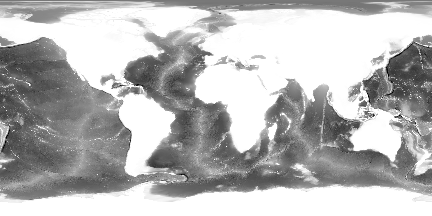


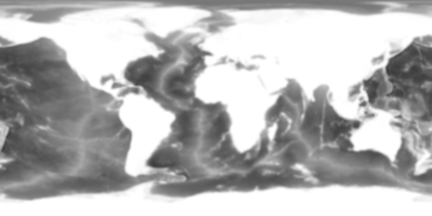

In [8]:
# Bathymetry?
# Importing Image and ImageFilter module from PIL package  
from PIL import Image, ImageFilter
if use_bath:
    img = Image.open(bath_tex)
    depth = np.array(img)
    print(depth.shape, depth.min(), depth.max(), depth.dtype)
    #Renders a jpeg downsampled view
    depth = depth.reshape(depth.shape[0],depth.shape[1],1)
    image = lavavu.Image(data=depth[::50, ::50])
    image.display()
    img = img.convert('L')
    im2 = img.filter(ImageFilter.GaussianBlur(radius=50))
    depth_blur = np.array(im2)
    depth_blur = depth_blur.reshape(depth_blur.shape[0],depth_blur.shape[1],1)
    image = lavavu.Image(data=depth_blur[::50, ::50])
    image.display()
    

In [9]:
#Normalise then exaggerate height
height = height / 255.0 / 10.
print(height.shape, height.min(), height.max())
# Bathymetry?
if use_bath:
    depth_orig = depth
    depth = depth / 255.0 / 10. - 0.1
    print(depth.shape, depth.min(), depth.max())
    depth[depth==0.0] = 1.0
    #combined:
    if combine_bath:
        depth[depth == 0.0] = height[depth == 0.0]
        print(depth.shape, depth.min(), depth.max())
        height = depth
        combo = (((height + 0.1) * 5.0) * 255.0).astype(np.uint8)
        image = lavavu.Image(data=combo[::50, ::50])
        image.display()    

(10800, 21600, 1) 0.0 0.1
(10800, 21600, 1) -0.1 0.0


### Generate and Render 3D globe topography (and bathymetry)

In [10]:
#Split the topography equirectangular image into cube map tiles
heights = accessvis.split_tex(height, GRIDRES)
if use_bath:
    depths = accessvis.split_tex(depth, GRIDRES)

In [11]:
#For generating cube face grids
ij = np.linspace(-1., 1., GRIDRES, dtype='float32')
ii, jj = np.meshgrid(ij, ij) #2d grid
zz = np.zeros(shape=ii.shape, dtype='float32') #3rd dim
def face_verts(f):
    #Generate cube face grid
    if f == 'F':
        vertices = np.dstack((ii, jj, zz + 1.0))
    elif f == 'B':
        vertices = np.dstack((ii, jj, zz - 1.0))
    elif f == 'R':
        vertices = np.dstack((zz + 1.0, jj, ii))
    elif f == 'L':
        vertices = np.dstack((zz - 1.0, jj, ii))
    elif f == 'U':
        vertices = np.dstack((ii, zz + 1.0, jj))
    elif f == 'D':
        vertices = np.dstack((ii, zz - 1.0, jj))
    #Normalise the vectors to form spherical patch  (normalised cube)
    V = vertices.ravel().reshape((-1,3))
    norms = np.sqrt(np.einsum('...i,...i', V, V))
    norms = norms.reshape(GRIDRES,GRIDRES,1)
    verts = vertices / norms
    return verts

sdata = {}
bdata = {}
for f in ['F', 'R', 'B', 'L', 'U', 'D']:
    verts = face_verts(f)

    if use_bath:
        bdata[f] = verts * (depths[f] + radius)

    if use_topo:
        verts *= (heights[f] + radius) #Offset the heights and apply scaling
    else:
        verts *= radius #Smooth globe, no height map

    sdata[f] = verts

#Save compressed vertex data
np.savez_compressed('Topo' + tag, **sdata)
if use_bath:
    np.savez_compressed('Bath' + tag, **sdata)

In [12]:
if use_bath:
    depths = accessvis.split_tex(depth_orig, GRIDRES)
    depths_blur = accessvis.split_tex(depth_blur, GRIDRES)

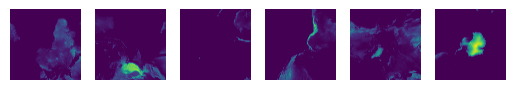

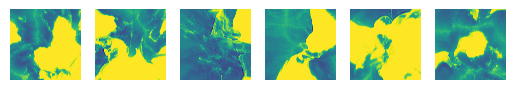

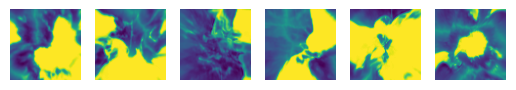

In [13]:
#Export individial textures too - topo / bath as png tex instead of numpy data
force = False #True

if force or not os.path.exists('F_topo' + res_tag + '.png'):
    #Write greyscale texture tiles
    for f in ['F', 'R', 'B', 'L', 'U', 'D']:
        tfn = f + '_topo' + res_tag + '.png'
        if force or not os.path.exists(tfn):
            img = (heights[f] * 10.0 * 255.0).astype(np.uint8)
            tex = lavavu.Image(data=img)
            tex.save(tfn)

if use_bath and (force or not os.path.exists('F_bath' + res_tag + '.png')):
    for f in ['F', 'R', 'B', 'L', 'U', 'D']:            
        tfn = f + '_bath' + res_tag + '.png'
        if use_bath and (force or not os.path.exists(tfn)):
            img = depths[f] #((depths[f]+0.1) * 10.0 * 255.0).astype(np.uint8)
            tex = lavavu.Image(data=img)
            tex.save(tfn)

if use_bath and (force or not os.path.exists('F_bath_blur' + res_tag + '.png')):
    for f in ['F', 'R', 'B', 'L', 'U', 'D']:
        tfn = f + '_bath_blur' + res_tag + '.png'
        if force or not os.path.exists(tfn):
            #Save blurred version
            img = depths_blur[f]
            tex = lavavu.Image(data=img)
            tex.save(tfn)

# display images
%matplotlib inline
fig, ax = plt.subplots(1,6) #, figsize=(12, 2))
for i,f in enumerate(['F', 'R', 'B', 'L', 'U', 'D']):
    ax[i].imshow(mpimg.imread(f+ '_topo' + res_tag + '.png'))
    ax[i].axis('off')
fig, ax = plt.subplots(1,6) #, figsize=(12, 2))
for i,f in enumerate(['F', 'R', 'B', 'L', 'U', 'D']):
    ax[i].imshow(mpimg.imread(f+ '_bath' + res_tag + '.png'))
    ax[i].axis('off')
fig, ax = plt.subplots(1,6) #, figsize=(12, 2))
for i,f in enumerate(['F', 'R', 'B', 'L', 'U', 'D']):
    ax[i].imshow(mpimg.imread(f+ '_bath_blur' + res_tag + '.png'))
    ax[i].axis('off')

# Visualise

[Sea water by ManyTextures.com ](https://www.manytextures.com/texture/23/sea-water/)is licensed under a Creative Commons Attribution 4.0 International License. 

NpzFile 'Topo_flat_high.npz' with keys: F, R, B, L, U...


bathymetry : No colourmap texture available! "B_bath_high.png"



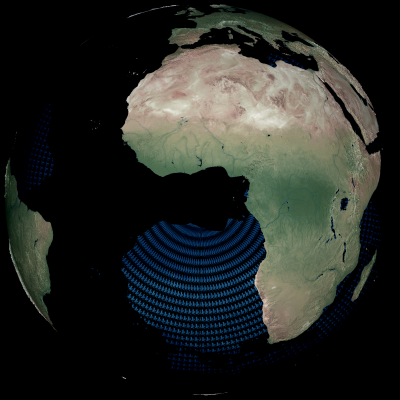

bathymetry_blur : No colourmap texture available! "B_bath_blur_high.png"
waves : No colourmap texture available! "sea-water-2048x2048_gs.png"
bathymetry : No colourmap texture available! "U_bath_high.png"
bathymetry_blur : No colourmap texture available! "U_bath_blur_high.png"
waves : No colourmap texture available! "sea-water-2048x2048_gs.png"
bathymetry : No colourmap texture available! "R_bath_high.png"
bathymetry_blur : No colourmap texture available! "R_bath_blur_high.png"
waves : No colourmap texture available! "sea-water-2048x2048_gs.png"
bathymetry : No colourmap texture available! "L_bath_high.png"
bathymetry_blur : No colourmap texture available! "L_bath_blur_high.png"
waves : No colourmap texture available! "sea-water-2048x2048_gs.png"
bathymetry : No colourmap texture available! "D_bath_high.png"
bathymetry_blur : No colourmap texture available! "D_bath_blur_high.png"
waves : No colourmap texture available! "sea-water-2048x2048_gs.png"
bathymetry : No colourmap texture avai

In [14]:
#Load topo vertex data
ldata = np.load('Topo' + tag + '.npz')
print(ldata)

#Visualise
lv = lavavu.Viewer(border=False, axis=False, resolution=[1280,720], background=background)

#Shading/colour settings
lv["brightness"] = -0.05 #-0.15
lv["contrast"] = 1.25
lv["saturation"] = 0.55 #0.35

#Custom uniforms / additional textures
uniforms = {}
uniforms["height"] = radius
#Public domain texture from: 
uniforms["waves"] = "sea-water-2048x2048_gs.png"

#shaders = ['triShader_grey.vert', 'triShader_grey.frag']
shaders = ['triShader_ocean.vert', 'triShader_ocean.frag']
for f in ['F', 'R', 'B', 'L', 'U', 'D']:
    verts = ldata[f]
    uniforms["bathymetry"] = f"{f}_bath{res_tag}.png"
    uniforms["bathymetry_blur"] = f"{f}_bath_blur{res_tag}.png"
    q = lv.quads(name=f, vertices=verts, texture=f + tag + '.png',
                 fliptexture=False, flip=f in ['F', 'L', 'D'], #Reverse facing
                 renderer="simpletriangles", opaque=True, shaders=shaders, uniforms=uniforms)

lv.translation(0.0, 0.0, -17)
#lv.rotation(0.0, -125.0, 0.0) #Australia view
lv.rotation(0.0, 0.0, 0.0) #Prime meridian view
lv.render()
lv.display((400,400))

In [15]:
#This opens a viewer on the machine where the notebook is running, if remote then don't use this
#lv.interactive()

In [16]:
#This opens a viewer in a web browser window on the remote machine, use this if running on gadi or other remote vis server
lv.interact()

<IPython.core.display.Javascript object>